In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr); library(dplyr)
library(RColorBrewer)
library(stats)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Running Pairwise Comparisons on fasta file of OTU seeds

In [ ]:
%%bash
ionice -c2 -n3 \
mothur "#pairwise.seqs(fasta=/home/chantal/Chazy/data/ComboFastaFiles/ITS/otusn.pick.fasta, calc=onegap, countends=false, \
processors=10, output=square)" #> /dev/null


In [ ]:
! tail /home/chantal/Chazy/data/ComboFastaFiles/ITS/otusn.pick.square.dist | cut -c1-80

In [ ]:
! grep -c "OTU" /home/chantal/Chazy/data/ComboFastaFiles/ITS/otusn.pick.square.dist

## Running t-SNE analysis on pairwise distance matrix

In [3]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from math import log

In [4]:
%matplotlib inline

In [5]:
dist_lines = open("/home/chantal/Chazy/data/ComboFastaFiles/ITS/otusn.pick.square.dist").readlines()
def line2array(line):
    line = line.rstrip()
    return np.array(map(float, line.split("\t")[1:]))
distmat = np.vstack([line2array(line) for line in dist_lines[1:]])

In [6]:
def getOTU(line):
    line = line.rstrip()
    return np.array(line.split("\t")[0:1])
OTU= np.vstack(getOTU(line) for line in dist_lines[1:])

In [7]:
print OTU

[['OTU.3     ']
 ['OTU.5     ']
 ['OTU.8     ']
 ..., 
 ['OTU.92997 ']
 ['OTU.93036 ']
 ['OTU.93059 ']]


In [8]:
print distmat

[[ 0.      0.2864  0.4064 ...,  0.4149  0.3     0.4188]
 [ 0.2935  0.      0.5    ...,  0.4359  0.3     0.    ]
 [ 0.4064  0.36    0.     ...,  0.3777  0.3989  0.414 ]
 ..., 
 [ 0.4149  0.4359  0.3777 ...,  0.      0.3333  0.4   ]
 [ 0.3     0.3     0.3989 ...,  0.3333  0.      0.4   ]
 [ 0.4188  0.3778  0.414  ...,  0.4     0.4     0.    ]]


In [9]:
def corr(a):
    if (a >= 0.75): return a
    else: return (-3/4*(log(1-(4/3*a))))

In [10]:
vecfunc = np.vectorize(corr)
result=vecfunc(distmat)

In [11]:
print result

[[-0.          0.3374327   0.52154959 ...,  0.53597251  0.35667494
   0.54266035]
 [ 0.34743208 -0.          0.69314718 ...,  0.57252374  0.35667494 -0.        ]
 [ 0.52154959  0.4462871  -0.         ...,  0.47433299  0.50899397
   0.53443549]
 ..., 
 [ 0.53597251  0.57252374  0.47433299 ..., -0.          0.40541511
   0.51082562]
 [ 0.35667494  0.35667494  0.50899397 ...,  0.40541511 -0.          0.51082562]
 [ 0.54266035  0.47449369  0.53443549 ...,  0.51082562  0.51082562 -0.        ]]


In [12]:
model = TSNE(n_components=2, random_state=0)
tsne_coords = model.fit_transform(result) 

In [13]:
tsne_coords

array([[  9.86987381,   7.78588127],
       [  8.04426439,  17.27334821],
       [ -6.3293725 , -10.83914555],
       ..., 
       [  4.87392765,  -6.86454655],
       [  3.89350396,   6.03464434],
       [-11.8983959 ,   1.09228365]])

In [14]:
combo = np.concatenate((tsne_coords, OTU), axis = 1)

In [15]:
combo

array([['9.86987380716', '7.78588127423', 'OTU.3     '],
       ['8.04426438695', '17.2733482056', 'OTU.5     '],
       ['-6.32937250336', '-10.8391455474', 'OTU.8     '],
       ..., 
       ['4.87392765215', '-6.86454655217', 'OTU.92997 '],
       ['3.89350396416', '6.0346443381', 'OTU.93036 '],
       ['-11.8983958979', '1.09228365049', 'OTU.93059 ']], 
      dtype='|S32')

## Visualizing t-SNE coordinates

/opt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


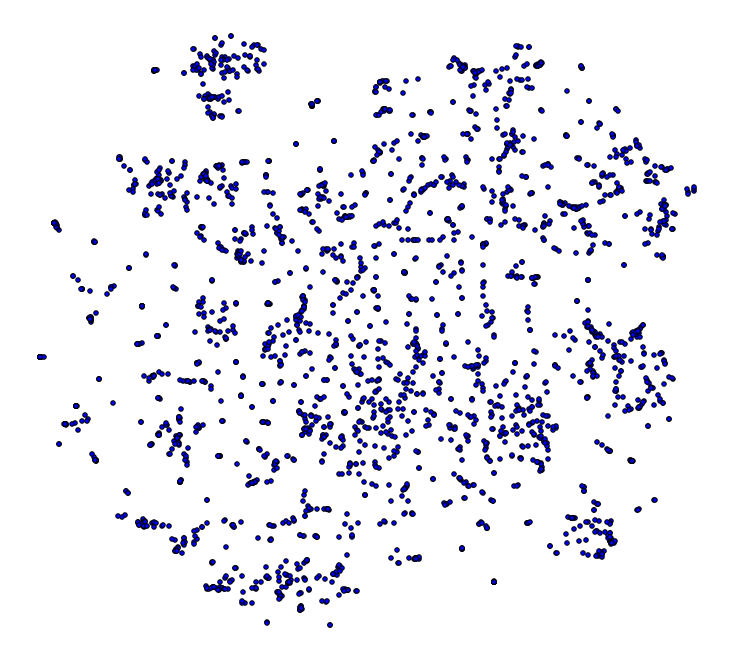

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(combo[:, 0], combo[:, 1])

## Importing python variables of t-SNE coordinates into R

In [17]:
%Rpush combo

In [18]:
%%R
colnames(combo) = c("tsne_1", "tsne_2", "OTU")

In [19]:
%%R
combo = as.data.frame(combo)

In [20]:
%%R
head(combo)

          tsne_1         tsne_2        OTU
1  9.86987380716  7.78588127423 OTU.3     
2  8.04426438695  17.2733482056 OTU.5     
3 -6.32937250336 -10.8391455474 OTU.8     
4 -5.13967551295  -9.4392943111 OTU.11    
5 -6.60081019802 -8.06360377654 OTU.13    
6 -5.07846160568 -9.40852160358 OTU.15    


In [21]:
%%R
combo$OTU = gsub(" ", "", combo$OTU, fixed = TRUE)

In [22]:
%%R
head(combo)

          tsne_1         tsne_2    OTU
1  9.86987380716  7.78588127423  OTU.3
2  8.04426438695  17.2733482056  OTU.5
3 -6.32937250336 -10.8391455474  OTU.8
4 -5.13967551295  -9.4392943111 OTU.11
5 -6.60081019802 -8.06360377654 OTU.13
6 -5.07846160568 -9.40852160358 OTU.15


## Creating csv with t-SNE information

In [23]:
%%R
write.table(combo, "data/tSNE.csv", row.names = FALSE, sep = ",")

# Start notebook here if just visualizing t-SNE

In [24]:
%%R
combo = read.csv("data/tSNE.csv")

In [25]:
%%R
length(combo$OTU)

[1] 2882


## Adding Metadata to t-SNE coordinates

In [26]:
%%R
physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [27]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS",
                           physeq.Bulk)
    
physeq.Bulk.m = physeq.Bulk.core %>% sample_data

physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2412 taxa and 185 samples ]
sample_data() Sample Data:       [ 185 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2412 taxa by 7 taxonomic ranks ]


In [28]:
%%R
mdf = psmelt(physeq.Bulk) 

In [29]:
%%R
mdf$OTU = as.factor(mdf$OTU)

In [30]:
%%R
str(combo$OTU)

 Factor w/ 2882 levels "OTU.100","OTU.1001",..: 1067 1744 2624 66 182 314 562 604 743 832 ...


In [31]:
%%R
d2 = left_join(mdf, combo, by = 'OTU')

In [32]:
%%R
length(unique(d2$OTU))

[1] 2412


In [33]:
%%R
d2 %>% group_by(Rank1) %>% unique() %>% summarise(n = n())

Source: local data frame [3 x 2]

        Rank1      n
       (fctr)  (int)
1    k__Fungi 415695
2  k__Plantae  13875
3 k__Protista  16650


In [34]:
%%R 
length(unique(d2$OTU))

[1] 2412


In [35]:
%%R
d2$Month = factor(d2$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))


## Visualizing t-SNE Coordinates with Metadata painted on

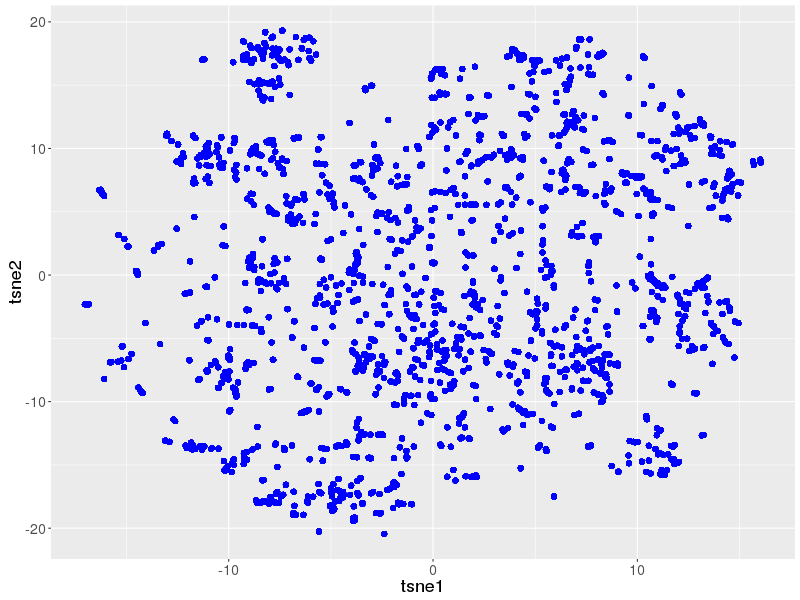

In [36]:
%%R -w 800 -h 600

my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(fill = "blue", color = "blue", size = 2, pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))  + 
    #scale_colour_gradient(limits = c(0, 1), low="red", high="blue", name = "Adjusted p-value") +
    guides(color=FALSE) + theme(text = element_text(size=18)) 


p = p + xlab("tsne1") + ylab("tsne2")


p   

In [37]:
%%R
ggsave("data/figs/tnseFig_nolabels.png", p, height = 7, width = 7)

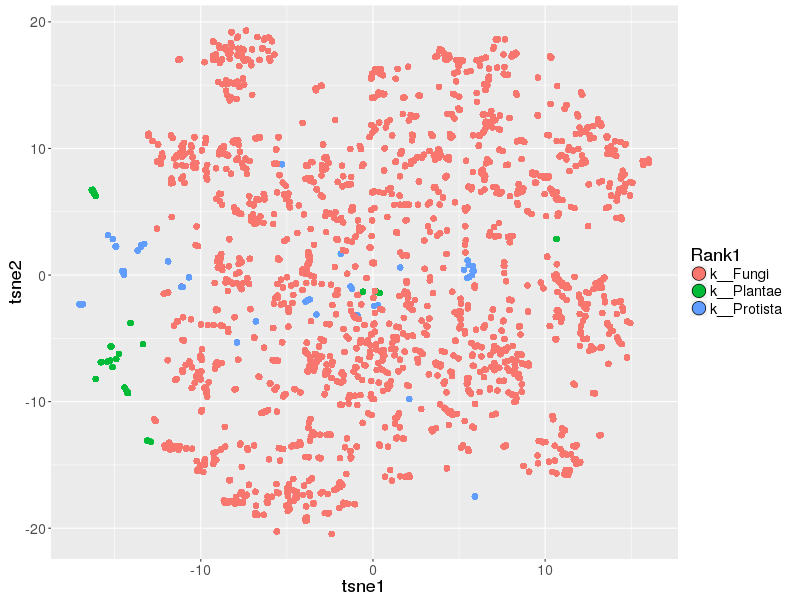

In [38]:
%%R -w 800 -h 600

my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = Rank1, color = Rank1), size = 2, pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))  + 
    #scale_colour_gradient(limits = c(0, 1), low="red", high="blue", name = "Adjusted p-value") +
    guides(color=FALSE) + theme(text = element_text(size=18)) 


p = p + xlab("tsne1") + ylab("tsne2")


p   

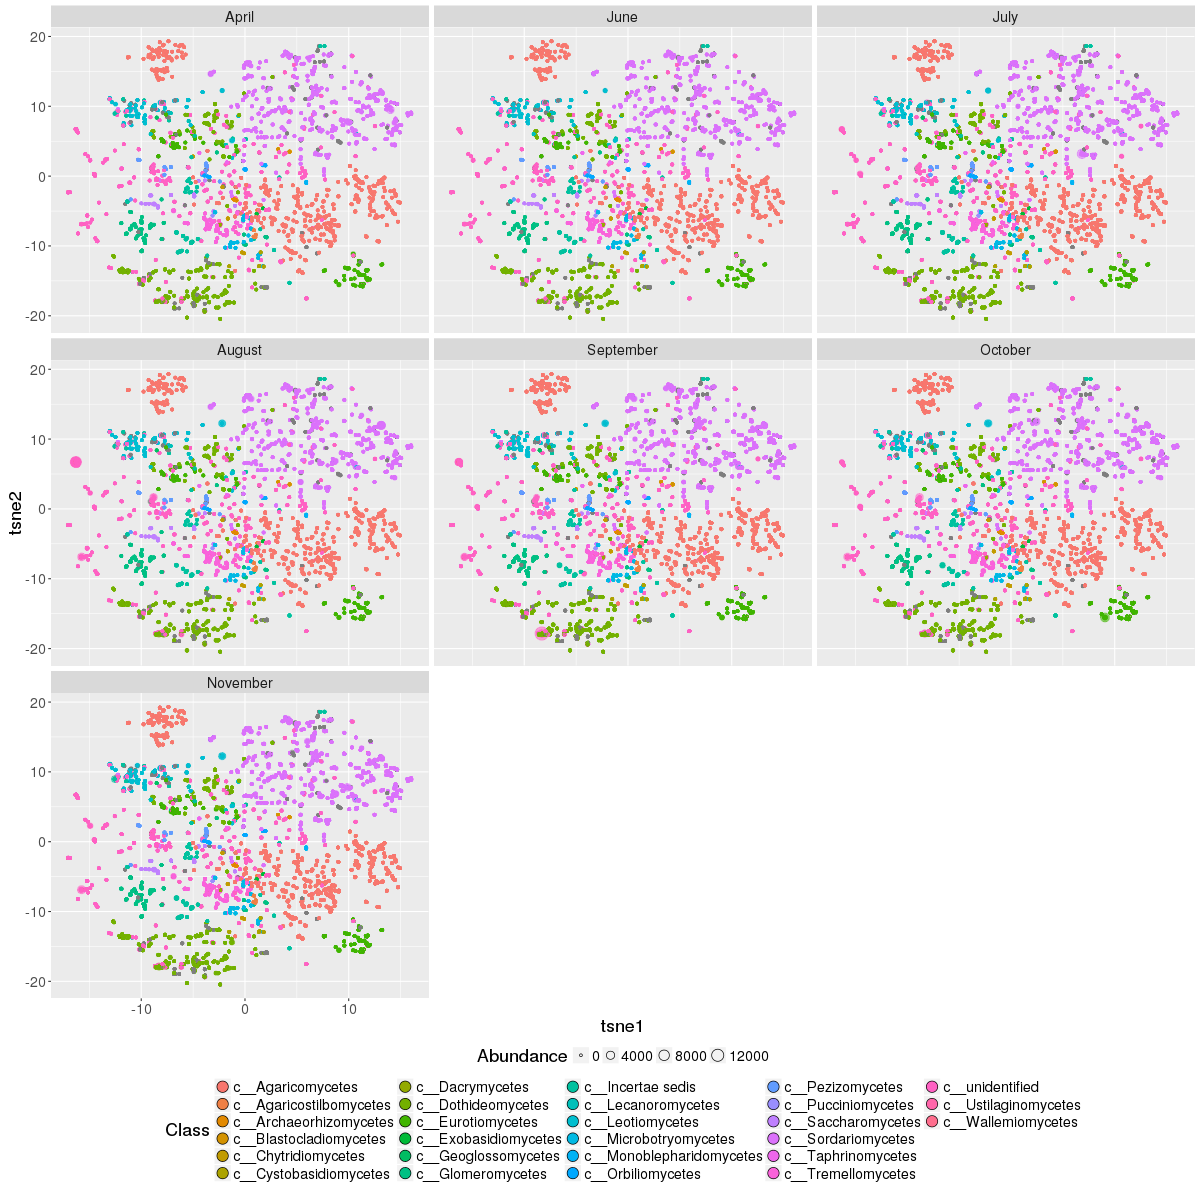

In [39]:
%%R -w 1200 -h 1200

#my_palette <- c("green", "red", "blue")
d2 = filter(d2, !(is.na(Sample_Date)))

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = Rank3, color = Rank3, size = Abundance, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) +
    scale_fill_discrete(name = "Class") +
    guides(color=FALSE) + theme(text = element_text(size=18)) 

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")

p = p + facet_wrap(~Month)

#p = p + guides(fill = FALSE)


p   

## Adding in LFC information

In [40]:
%%R
Till = read.table('data/l2fc_Till.txt', sep = '\t', header = TRUE)
OM = read.csv('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep = '\t', header = TRUE)

In [41]:
%%R
Till = plyr::rename(Till, c(log2FoldChange = "LFC_Till", padj2 = "p_Till"))

OM = OM %>% select(OTU, log2FoldChange, padj2, OM)
OM = plyr::rename(OM, c(log2FoldChange = "LFC_OM", padj2 = "p_OM"))

print(head(Till))
print(head(OM))

  sparsity_threshold      OTU   LFC_Till     lfcSE         padj       Rank1
1               0.15 OTU.7528  0.2249279 0.6348938 7.617212e-01 k__Protista
2               0.15 OTU.7100 -1.9549789 0.6699598 6.396375e-03 k__Protista
3               0.15 OTU.6084 -3.4615402 0.5619225 2.972063e-09 k__Protista
4               0.15 OTU.4797  2.7362826 0.5976881 1.275533e-05 k__Protista
5               0.15 OTU.2605  1.7587146 0.5286705 1.734853e-03    k__Fungi
6               0.15 OTU.2703  2.0622789 0.3536219 2.056414e-08 k__Protista
            Rank2           Rank3           Rank4           Rank5
1     p__Cercozoa c__unidentified o__unidentified f__unidentified
2     p__Cercozoa c__unidentified o__unidentified f__unidentified
3     p__Cercozoa c__unidentified o__unidentified f__unidentified
4     p__Cercozoa c__unidentified o__unidentified f__unidentified
5 p__unidentified c__unidentified o__unidentified f__unidentified
6     p__Cercozoa c__unidentified o__unidentified f__unidentified
      

In [42]:
%%R
data.total = full_join(combo, Till)
data.total.2 = full_join(data.total, OM)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [43]:
%%R
head(data.total)
length(data.total.2$OTU)

[1] 2882


In [44]:
%%R
length(Till$OTU)

[1] 454


In [45]:
%%R
test = intersect(Till$OTU, combo$OTU)

In [49]:
%%R
test  = filter(data.total.2, p_Till <=0.10)
length(test$OTU)

[1] 318


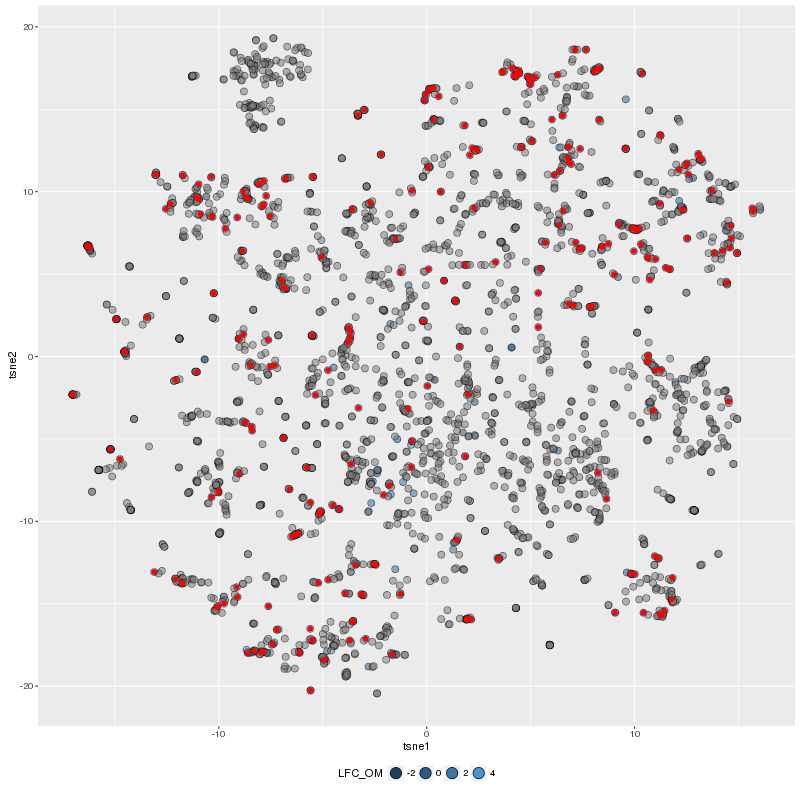

In [107]:
%%R -w 800 -h 800

my_palette <- c("green", "red", "blue")


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(data.total.2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = LFC_OM, alpha = 0.85), pch = 21, size = 3) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) 
    

p = p + geom_point(data = subset(data.total.2, p_Till <= 0.10), shape = 20, size = 3, color = "red")

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")


#p = p + guides(fill = FALSE)


p   

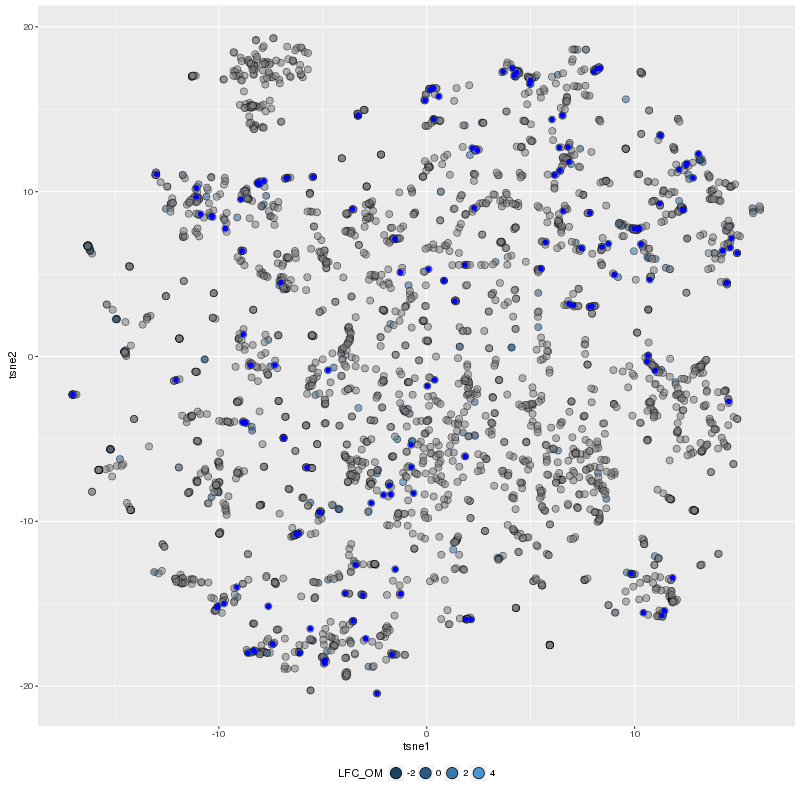

In [109]:
%%R -w 800 -h 800

my_palette <- c("green", "red", "blue")


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(data.total.2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = LFC_OM, alpha = 0.85), pch = 21, size = 3) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) 
    

p = p + geom_point(data = subset(data.total.2, p_OM <= 0.10), shape = 20, size = 3, color = "blue")

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")


#p = p + guides(fill = FALSE)


p   

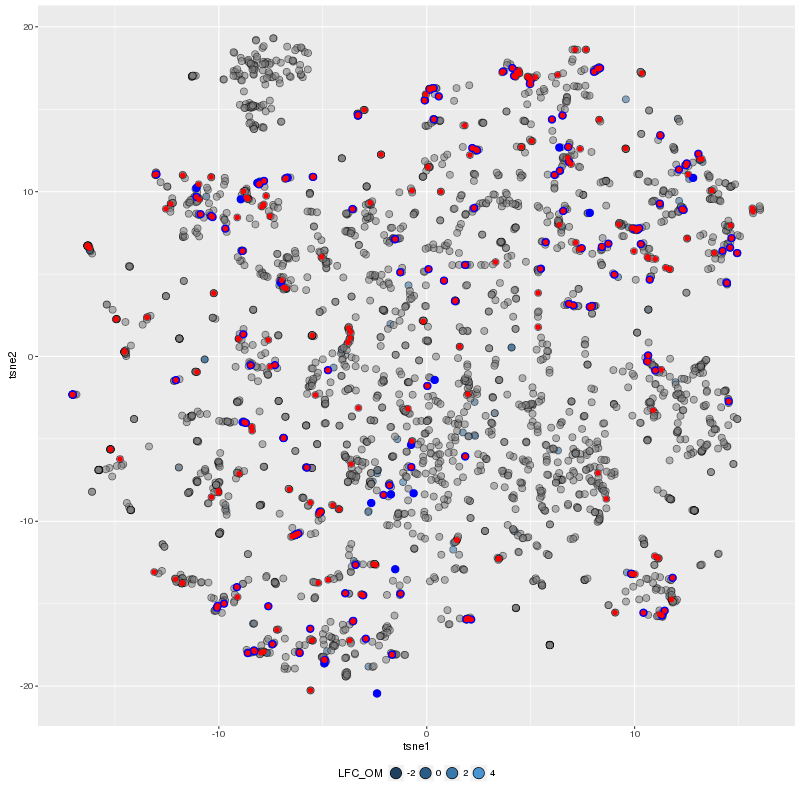

In [111]:
%%R -w 800 -h 800

my_palette <- c("green", "red", "blue")


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(data.total.2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = LFC_OM, alpha = 0.85), pch = 21, size = 3) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) 
    

p = p + geom_point(data = subset(data.total.2, p_OM <= 0.10), shape = 20, size = 5, color = "blue")
p = p + geom_point(data = subset(data.total.2, p_Till <= 0.10), shape = 20, size = 3, color = "red")

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")


#p = p + guides(fill = FALSE)


p   

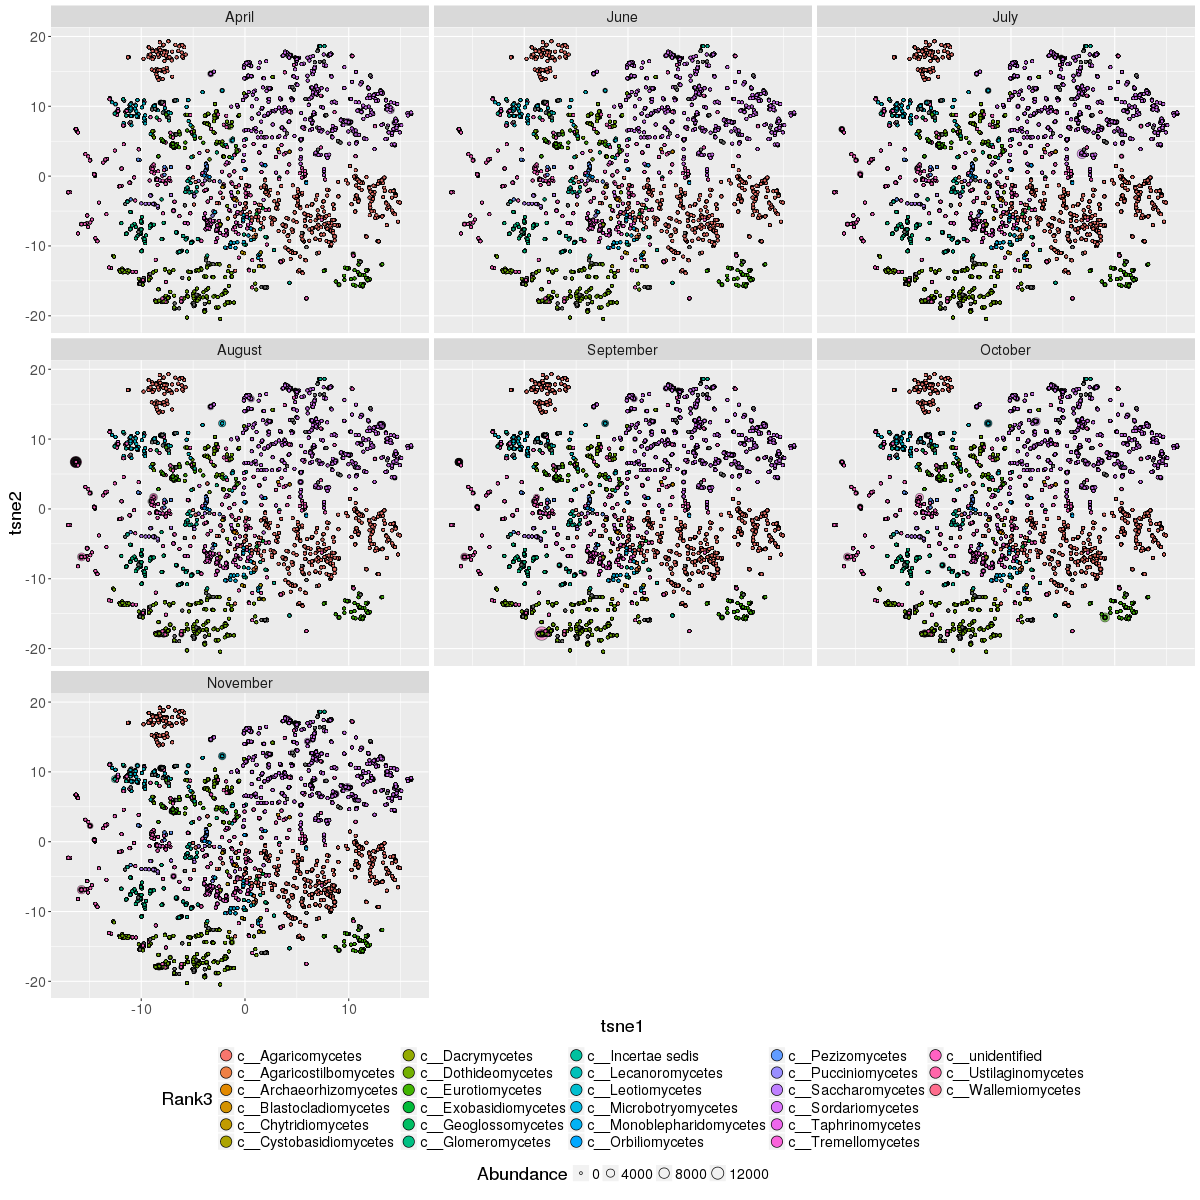

In [112]:
%%R -w 1200 -h 1200

my_palette <- c("green", "red", "blue")


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = Rank3, alpha = 0.85, size = Abundance), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) +
    #scale_shape_discrete(name = "Responder Status") + 
   # scale_fill_discrete(name = "Responder Status")+
    guides(color=FALSE) + theme(text = element_text(size=18)) 

#p = p + geom_point(data = subset(d2, Rank3 == "c__unidentified"), aes(size = Resp_status), pch = 8,
 #                  alpha = 0.5)

p = p + theme(legend.position ="bottom")

p = p + xlab("tsne1") + ylab("tsne2")

p = p + facet_wrap(~Month)

#p = p + guides(fill = FALSE)


p     

In [52]:
%%R
filter(d2, Month == 'September', tsne_1 < -5, tsne_2 <= -15, padj2 <=0.05)


Error in eval(expr, envir, enclos) : object 'padj2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'padj2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘S4Vectors::Position’ by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/

In [53]:
%%R
ggsave("data/figs/tnseFig_resp.png", p, height = 8, width = 8)

In [54]:
%%R

na = filter(d2, is.na(Rank3))
rest = filter(d2, !is.na(Rank3))
na$group = "Unclassified"
rest$group = rest$Rank3
g = rbind(na, rest)

In [55]:
%%R
head(g)

      OTU          Sample Abundance     Full.sample Fraction PrimerF PrimerR
1 OTU.321  Aug.PTR.2.2015      1728  Aug.PTR.2.2015       NA  nBITSf   58A2r
2 OTU.144    July15.PTH.1      1592    July15.PTH.1       NA  nBITSf   58A2r
3 OTU.144  Nov.PTR.2.2015      1488  Nov.PTR.2.2015       NA  nBITSf   58A2r
4 OTU.267  Nov.PTH.1.2015      1487  Nov.PTH.1.2015       NA  nBITSf   58A2r
5  OTU.25  Aug.PTH.3.2015      1399  Aug.PTH.3.2015       NA  nBITSf   58A2r
6 OTU.321 Sept.PTR.2.2015      1279 Sept.PTR.2.2015       NA  nBITSf   58A2r
  Barcode Rev.index Fwd.index Treatment Day Pool     Experiment Gradient
1     124  tctctatg  ctgcgtgt       PTR  NA    5 Chazy.ITS.Bulk     <NA>
2     175  tgctcgta  ggatatct       PTH  NA    4 Chazy.ITS.Bulk     <NA>
3     178  aacgctga  actatctg       PTR  NA    5 Chazy.ITS.Bulk     <NA>
4     172  tgctcgta  ctgcgtgt       PTH  NA    5 Chazy.ITS.Bulk     <NA>
5     126  tctctatg  cgtgagtg       PTH  NA    5 Chazy.ITS.Bulk     <NA>
6     143  gtaacgag  gg

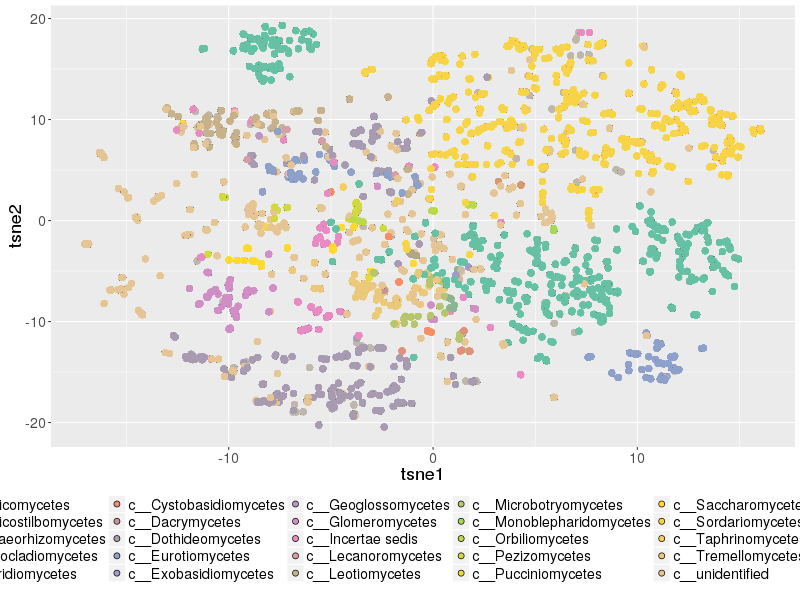

In [56]:
%%R -w 800 -h 600

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p2 = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))
#p = p + geom_point(data = subset(d2, padj <= 0.10), shape = 20, size = 6)
p2 = p2 + geom_point(aes(fill = group, color = group, alpha = 0.85), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=5))) +
    guides(colour=FALSE)

colourCount = length(unique(g$group)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set2"))
p2 = p2 + scale_color_manual(values = getPalette(colourCount))
p2 = p2 + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)
p2 = p2 + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=6))
#p2 = p2 + guides(fill = FALSE)




p2 = p2 + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 


p2   

In [57]:
%%R
tiff("data/figs/tnse.tax.tiff", res = 75, )
grid.arrange(p, p2, ncol=2)
dev.off()

png 
  2 


In [58]:
%%R -w 800 -h 600

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))
p = p + geom_point(data = subset(g, padj <= 0.10), shape = 20, size = 7)
p = p + geom_point(aes(fill = group, color = group), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
    guides(colour=FALSE)

colourCount = length(unique(d2$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_color_manual(values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)


p = p + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 
p = p + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=4)) + stat_ellipse(data = poss_Sords)



p     


Error in eval(expr, envir, enclos) : object 'padj' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'padj' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In brewer.pal(10, "Set2") :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [59]:
%%R
head(g)

      OTU          Sample Abundance     Full.sample Fraction PrimerF PrimerR
1 OTU.321  Aug.PTR.2.2015      1728  Aug.PTR.2.2015       NA  nBITSf   58A2r
2 OTU.144    July15.PTH.1      1592    July15.PTH.1       NA  nBITSf   58A2r
3 OTU.144  Nov.PTR.2.2015      1488  Nov.PTR.2.2015       NA  nBITSf   58A2r
4 OTU.267  Nov.PTH.1.2015      1487  Nov.PTH.1.2015       NA  nBITSf   58A2r
5  OTU.25  Aug.PTH.3.2015      1399  Aug.PTH.3.2015       NA  nBITSf   58A2r
6 OTU.321 Sept.PTR.2.2015      1279 Sept.PTR.2.2015       NA  nBITSf   58A2r
  Barcode Rev.index Fwd.index Treatment Day Pool     Experiment Gradient
1     124  tctctatg  ctgcgtgt       PTR  NA    5 Chazy.ITS.Bulk     <NA>
2     175  tgctcgta  ggatatct       PTH  NA    4 Chazy.ITS.Bulk     <NA>
3     178  aacgctga  actatctg       PTR  NA    5 Chazy.ITS.Bulk     <NA>
4     172  tgctcgta  ctgcgtgt       PTH  NA    5 Chazy.ITS.Bulk     <NA>
5     126  tctctatg  cgtgagtg       PTH  NA    5 Chazy.ITS.Bulk     <NA>
6     143  gtaacgag  gg

In [60]:
%%R
poss_Sords = filter(g, padj <= 0.10, Rank3 %in% c("unidentified", 'Unclassified')) %>% arrange(tsne_2, tsne_1)
length(unique(poss_Sords$OTU))
poss_Sords


Error in eval(expr, envir, enclos) : object 'padj' not found


In [61]:
%%R
ggsave("data/figs/tnseFig.jpg", p, height = 8, width =10 )

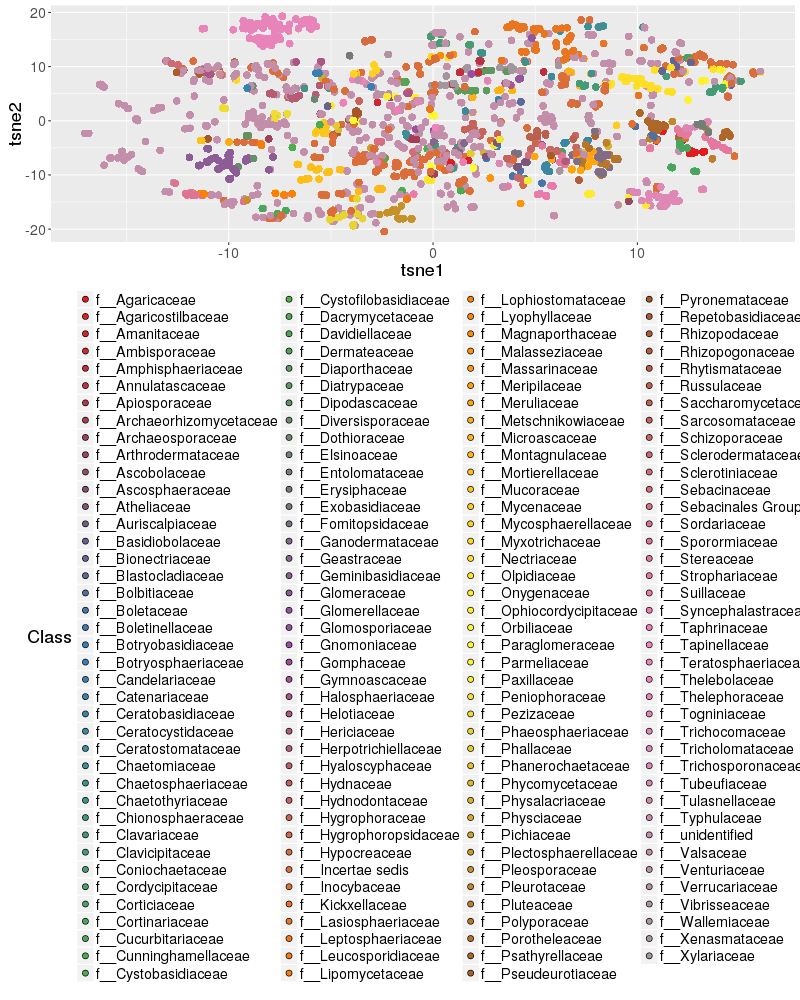

In [62]:
%%R -w 800 -h 1000

#my_palette <- colorRampPalette(c("red", "yellow", "green"))(n = 299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(g, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))
#p = p + geom_point(data = subset(d2, padj <= 0.10), shape = 20, size = 7)
p = p + geom_point(aes(fill = Rank5, color = Rank5), pch = 21, size = 2.5) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(limits = c(0, 1), low="blue",high="green") + 
    #scale_colour_gradient(limits = c(0, 1), low="blue", high="green", name = "adjusted p-value") +
    guides(colour=FALSE)

colourCount = length(unique(d2$Rank5)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_color_manual(values = getPalette(colourCount))
p = p + scale_fill_manual(values = getPalette(colourCount), name = "Class")+ theme(text = element_text(size=18)) 

#p = p  + geom_point(data = subset(d2, Rank3 %in% c('unclassified', 'unidentified')), color = "black", size = 2)


p = p + xlab("tsne1") + ylab("tsne2") +  guides(color=FALSE) 
p = p + theme(legend.position= "bottom") + guides(fill=guide_legend(ncol=4))



p     

In [63]:
%%R -w 800 -h 300

dcounts = d2 %>%
          group_by(Day,Rank2) %>%
          summarize(responders = sum(padj<= 0.10)) 

dcounts = filter(dcounts, responders !=0)          
dcounts$Rank2[is.na(dcounts$Rank2)] = "p__unidentified"

p2 = ggplot(dcounts, aes(x = Rank2 , y = responders, fill = Rank2)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity") +
    xlab("Phyla") + ylab("responder count") +
    scale_x_discrete(breaks=NULL) +
    scale_fill_discrete(name = "Phyla", labels = c("Ascomycota", "Basidiomycota", "Unidentified"))
                        

p2


Error in eval(expr, envir, enclos) : object 'padj' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In brewer.pal(10, "Set1") :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [64]:
%%R
ggsave("data/figs/responderCounts.jpg", p2, height = 3, width = 8)

In [65]:
%%R
tail(filter(d2, Rank2 == "p__unidentified"))

           OTU       Sample Abundance  Full.sample Fraction PrimerF PrimerR
36070 OTU.9597 July14.NTR.1         0 July14.NTR.1       NA  nBITSf   58A2r
36071 OTU.9597    Nov.NTR.4         0    Nov.NTR.4       NA  nBITSf   58A2r
36072 OTU.9597  April.NTH.4         0  April.NTH.4       NA  nBITSf   58A2r
36073 OTU.9597   Sept.NTH.2         0   Sept.NTH.2       NA  nBITSf   58A2r
36074 OTU.9597    Oct.PTR.2         0    Oct.PTR.2       NA  nBITSf   58A2r
36075 OTU.9597   Sept.PTH.3         0   Sept.PTH.3       NA  nBITSf   58A2r
      Barcode Rev.index Fwd.index Treatment Day Pool     Experiment Gradient
36070     140  gtaacgag  ctgcgtgt       NTR  NA    4 Chazy.ITS.Bulk     <NA>
36071     128  tctctatg  gacaccgt       NTR  NA    4 Chazy.ITS.Bulk     <NA>
36072     153  atagtacc  atcgtacg       NTH  NA    4 Chazy.ITS.Bulk     <NA>
36073      89  tatagcga  atcgtacg       NTH  NA    4 Chazy.ITS.Bulk     <NA>
36074     118  tagcagct  cgtgagtg       PTR  NA    4 Chazy.ITS.Bulk     <NA>
36075 

In [66]:
%%R -w 1000 -h 300

dcounts = d2 %>%
          group_by(Day,Rank3) %>%
          summarize(responders = sum(padj<= 0.10)) 

dcounts = filter(dcounts, responders !=0)          


p = ggplot(dcounts, aes(x = Rank3 , y = responders, fill = Rank3)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity")

p


Error in eval(expr, envir, enclos) : object 'padj' not found


In [67]:
%%R -w 1000 -h 400

dcounts = d2 %>%
          filter(padj <= 0.10) %>%
          group_by(Rank5) %>%
          mutate(responders = sum(length(unique(OTU))))%>%
          ungroup()  

dcounts = filter(dcounts, responders > 0)          


p = ggplot(dcounts, aes(x = Rank5 , y = responders, fill = Rank5)) +
    facet_wrap(~ Rank3, scales = "free_y", ncol =5) +
    geom_bar(stat = "identity") 
p


Error in eval(expr, envir, enclos) : object 'padj' not found


In [68]:
%%R
head(d2) %>% as.data.frame

     OTU          Sample Abundance     Full.sample Fraction PrimerF PrimerR
1 OTU.26 Sept.NTH.1.2015     15890 Sept.NTH.1.2015       NA  nBITSf   58A2r
2 OTU.81  Aug.NTH.1.2015     10261  Aug.NTH.1.2015       NA  nBITSf   58A2r
3 OTU.81  Aug.NTH.4.2015      7849  Aug.NTH.4.2015       NA  nBITSf   58A2r
4 OTU.81  Aug.NTH.2.2015      7208  Aug.NTH.2.2015       NA  nBITSf   58A2r
5 OTU.81  Aug.NTH.3.2015      6821  Aug.NTH.3.2015       NA  nBITSf   58A2r
6 OTU.77  Aug.NTH.1.2015      6663  Aug.NTH.1.2015       NA  nBITSf   58A2r
  Barcode Rev.index Fwd.index Treatment Day Pool     Experiment Gradient
1     136  gatctacg  gacaccgt       NTH  NA    5 Chazy.ITS.Bulk     <NA>
2     119  tagcagct  ggatatct       NTH  NA    5 Chazy.ITS.Bulk     <NA>
3     131  gatctacg  tagcgagt       NTH  NA    5 Chazy.ITS.Bulk     <NA>
4     123  tctctatg  tagcgagt       NTH  NA    5 Chazy.ITS.Bulk     <NA>
5     127  tctctatg  ggatatct       NTH  NA    5 Chazy.ITS.Bulk     <NA>
6     119  tagcagct  ggatatct 

In [69]:
%%R -w 1000 -h 400

dcounts = d2 %>%
          group_by(Rank5) %>%
          filter(padj<=0.10, Rank3 == "Sordariomycetes") %>%
          mutate(responders = sum(length(unique(OTU))))%>%
          ungroup()  

dcounts = filter(dcounts, responders > 0)          


p = ggplot(dcounts, aes(x = Rank5 , y = responders, fill = Rank5)) +
    facet_wrap(~ Rank3, scales = "free_y", ncol =5) +
    geom_bar(stat = "identity") 
p


Error in eval(expr, envir, enclos) : object 'padj' not found


In [70]:
%%R
d3 = filter(d2, padj <=0.10)
d3$tsne_1 = asNumeric(d3$tsne_1)
d3$tsne_2 = asNumeric(d3$tsne_2)
d3 = filter(d3, tsne_1 > 19)
d3 = filter(d3, tsne_2 > 7)
d3 = filter(d3, tsne_2 <13)


Error in eval(expr, envir, enclos) : object 'padj' not found


In [71]:
%%R
length(d3$OTU)


Error in withVisible({ : object 'd3' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'd3' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [72]:
%%R -w 600 -h 600

my_palette <- colorRampPalette(c("red", "yellow", "green"))(n =299)


asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(d3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = padj, color = padj, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    scale_fill_gradient(low="red",high="yellow") + scale_colour_gradient(low="red",high="yellow") +
    guides(fill=FALSE)


p     


Error in ggplot(d3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2))) : 
  object 'd3' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(d3, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2))) : 
  object 'd3' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [73]:
%%R
OTUs = d3$OTU 


Error in withVisible({ : object 'd3' not found


In [74]:
%%R
counts = filter(d, OTU %in% OTUs)


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'd' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'd' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [75]:
%%R
head(dcounts)


Error in head(dcounts) : object 'dcounts' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(dcounts) : object 'dcounts' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [76]:
%%R

dcounts = d3 %>%
          group_by(Day,Rank6) %>%
          summarize(responders = sum(padj<= 0.10))

p = ggplot(dcounts, aes(x = Rank6 , y = responders, fill = Rank6)) +
    facet_grid(. ~ Day, scales = "free_x", space = "free") +
    geom_bar(stat = "identity")


#px = ggplot(d, aes(x = factor(Day), y = responders, fill = RNA_DNA))

#px = px + facet_grid(. ~ Day, scales = "free_x", space = "free")

#px = px + geom_bar(stat = "identity", position = "dodge")

    #geom_point(aes(fill = padj, color = padj, alpha = 0.85), pch = 21) +
    #uides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) +
    #scale_fill_gradient(low="red",high="yellow") + scale_colour_gradient(low="red",high="yellow") +
    #guides(fill=FALSE)
p


Error in eval(expr, envir, enclos) : object 'd3' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'd3' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [77]:
%%R
head(d3)


Error in head(d3) : object 'd3' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(d3) : object 'd3' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


###Blasting vs. Living Tree Project for Responders

In [78]:
%%R
resp = filter(d2, padj<=0.10)


Error in eval(expr, envir, enclos) : object 'padj' not found


In [79]:
%%R
q = arrange(resp, padj)
OTU = unique(q$OTU)
length(OTU)


Error in arrange_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'resp' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in arrange_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'resp' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [80]:
%%R
head(OTU, n = 10)


Error in head(OTU, n = 10) : object 'OTU' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(OTU, n = 10) : object 'OTU' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [81]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [82]:
from cogent import LoadSeqs, DNA

In [83]:
%%bash
formatdb -i /home/chantal/FungalSIP/data/tmp/db/its_12_11_otus/rep_set/97_otus.fasta -p F

In [84]:
OTU_ids = ["OTU.98", "OTU.49", "OTU.53", "OTU.90", "OTU.279", "OTU.6893", "OTU.460", "OTU.6893"]
seqs = LoadSeqs("/home/chantal/FungalSIP/data/otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.279
TTACCGAGTTTACAACTCCCAAACCCAATGTGAACCATACCTAGACGTTGCTTCGGCGGTACCGCCCCGGCGCCCTCGGGCCCGGAACCAGGCGCCCGCCGGGGGACCAACCAAACCCTTTCAGTGAATCCCGGGCGACCCCCGGCGGCATTATCTGAGTACAGCGAAATAAAAAACGCATCAAAACTTTCAACAACGGATCTCTTGGTTCTGGC
>OTU.460
TTACAGAGTTGCAAAACTCCCTAAACCATTGTGAACGTTACCTAAACCGTTGCTTCGGCGGGCGGCCCCGGGGTTTACCCCCCGGGCGCCCCTGGGCCCCACCGCGGGCGCCCGCCGGAGGTCACCAAACTCTTGAATTACATGGCCTCTCTGAGTCTTCTGTACTGAATAAGTCAAAACTTTCAACAACGGATCTCTTGGTTCTGGC
>OTU.49
TTACAGAGTTGCAAAACTCCCTAAACCATTGTGAACCTTACCCAAACCGTTGCTTCGGCGGGCGGCGCACCGCGCCCCCCGGCCCCTCGCGGGCGCCCGCCGGAGGTACCCAAACCATTGATACTTTATGGCCTCTCTGAGTCTTCTGTACTGAATAAGTCAAAACTTTCAACAACGGATCTCTTGGTTCTGGC
>OTU.53
TTACCGAGTGTAAAAACTCCCAAACCATTGTGAACCTACCACTGTTGCTTCGGCGGCCTCGCCCCGGGCGCGTTCGCGCGGCCCGGACCCAGGCGTCCGCCGGAGGCTCCAAACTCTTGTCTTTTAGTGTATTTCTGAGTGGCATAAGCAAATAAATCAAAACTTTCAGCAACGGATCTCTTGGTTCTGGC
>OTU.6893
TTACAGAGTTGCAACACTCCCTTAACCATCGTGAACGTTACCCAAACCGTTGCTTCGGCGGGCGGCGCCCCGGCGCCCCCCGGCCCCTCGCGGGCGCCCGCCGGAGGTACCCAAACCATTGATACTTTATGGCCTCTCTGAGTC

In [85]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [86]:
cline = blast(query = "seqs.fasta",
              db = "/home/chantal/FungalSIP/data/tmp/db/its_12_11_otus/rep_set/97_otus.fasta",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /home/chantal/FungalSIP/data/tmp/db/its_12_11_otus/rep_set/97_otus.fasta -num_threads 5


('', '')

In [87]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.279" otusn_silvaRefNR115.m6

OTU.279	GQ169328	98.15	216	2	2	1	215	66	280	4e-104	  375
4030 otusn_silvaRefNR115.m6
613


In [88]:
from IPython.display import Image
import pandas.rpy.common as com

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  from ipykernel import kernelapp as app


In [89]:
%%R
library(data.table)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘data.table’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:reshape2’:

    dcast, melt


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106:

In [90]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) #%>% 
                          #filter(pid > 97.0) %>%
                          #filter(e.value < 5.0e-180) %>%
                          #filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [91]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

Source: local data frame [6 x 13]
Groups: OTU [1]

      OTU      acc   pid aln.length mismatches gapOpenCount qstart  qend sstart
    (chr)    (chr) (dbl)      (int)      (int)        (int)  (int) (int)  (int)
1 OTU.279 GQ169328 98.15        216          2            2      1   215     66
2 OTU.279 AF422973 95.79        214          5            4      4   215     36
3 OTU.279 AJ246149 95.35        215          6            3      1   215    108
4 OTU.279 FN392297 95.35        215          6            3      1   215      6
5 OTU.279 DQ865099 86.82        220         10           12      1   215     21
6 OTU.279 JN905732 82.11        218         12           15      1   215     66
Variables not shown: send (int), e.value (dbl), bit.score (dbl), Rank (int)
 chr [1:4030] "OTU.279" "OTU.279" "OTU.279" "OTU.279" "OTU.279" ...


In [92]:
! head data/tmp/db/its_12_11_otus/taxonomy/otu_taxonomy.txt

head: cannot open `data/tmp/db/its_12_11_otus/taxonomy/otu_taxonomy.txt' for reading: No such file or directory


In [93]:
%%R
dt = fread("data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt", sep = ";", header = FALSE)
dat1 <- data.frame(do.call(rbind, strsplit(as.vector(dt$V1), split = "\t")))
dt <- cbind(dat1, dt)
dt$V1 = NULL
colnames(dt) = c("acc","Kingdom","Phylum","Class","Order","Family","Genus", "Species")
ITS_seq_data = tbl_df(dt)
head(dt)


Error in fread("data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt",  : 
  File 'data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt' does not exist. Include one or more spaces to consider the input a system command.


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in fread("data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt",  : 
  File 'data/tmp/db/its_12_11_otus/taxonomy/97_otu_taxonomy.txt' does not exist. Include one or more spaces to consider the input a system command.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [94]:
%%R
joined_df = left_join(top_hits_df_LTP, ITS_seq_data)


Error in tbl_vars(y) : object 'ITS_seq_data' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in tbl_vars(y) : object 'ITS_seq_data' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [95]:
%%R
head(joined_df)


Error in head(joined_df) : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in head(joined_df) : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [96]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [97]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'joined_df' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [98]:
%%R
head(joined_df)


Error in head(joined_df) : object 'joined_df' not found


In [99]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["Genus", "Species","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("data/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="data/tmp" data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o data/table.png data/tmp/table.dvi >/dev/null 2>&1
Image("data/table.png")